In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import choices
import scipy.sparse as ss

In [37]:
from nltk.corpus import stopwords
import regex as re

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.svm import SVC
#Forests #Unfotunately I never got around to using them, however on principal I'd hope to at least try them at a later point in time

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning);

import pickle

In [3]:
df = pd.read_csv('../data/cleaned_02_ii.csv')
print(df.shape)
df.head()

(39565, 60)


,platform,text,hate_speech_score,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,...,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,hate_rank,capital_sentance,cleaned_text,wc_cleaned_text
0,0,White people are trash.,0.46,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,white peopl are trash,4
1,0,"You've caught the big gay, it's known to be ai...",0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,you ve caught the big gay it s known to be air...,14
2,0,"I'm not saying you said that, I'm just saying ...",-1.29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,i m not say you said that i m just say that if...,75
3,0,Donald Trump. Yeet myself off a building onto ...,-0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,donald trump yeet myself off a build onto a ga...,20
4,0,Fabrice Fabrice is ostensibly black or black/l...,-2.84,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,fabric fabric is ostens black or black latino ...,19


# Round I of modeling!

Reminder again that our target is somewhat ambiguous, tweaks to be adjusted to the 'cleaned text' among other things before the anticipated 'fun' of adding in other factors such as platform and target.

In [4]:
X = df['cleaned_text']
y = df['hate_rank']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25, #Given the size we'll start with this, a bit larger than what I'd usually do
                                                    random_state = 26, #I like this number
                                                    stratify=y) #Particularly important in this case with 3 targets

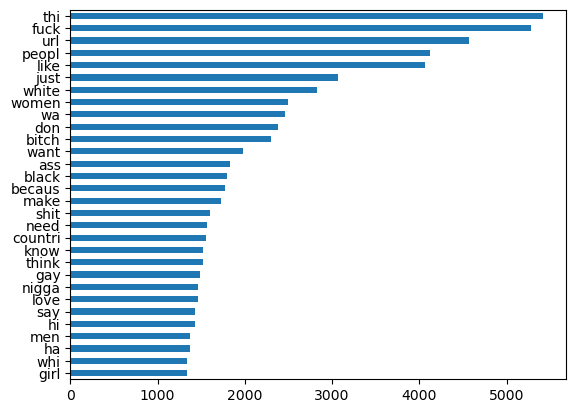

In [5]:
#For kicks, to get a bit of a taste of the upcoming data. 
cvec_ex = CountVectorizer(stop_words='english')
X_train_cvec_ex = cvec_ex.fit_transform(X_train)
X_train_ex = pd.DataFrame(X_train_cvec_ex.todense(),
                          columns=cvec_ex.get_feature_names_out())

X_train_ex.sum().sort_values().tail(30).plot(kind="barh");

Unsurprising, the 'f' word is high up there being the second mst common (only behind 'this'). Likely its presence, along with any other similar word, is more indicative of hate speech.

Other interesting words (tokens) include: just, b****, a**, white, black, woman, countri, n****, gay, men, and girl. Of particular interst to me is 'just'. Albeit it is a stopword, however

### Note:

Pragmatically go down to the next header. However, I wanted to preserve the following if you're really interested/bored.

In [6]:
# pipe = Pipeline([
#     ('cvec', CountVectorizer(lowercase=False))
#     ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial'))
# ])

# pipe_params = {'cvec__min_df' : [.05, .00]
#                ,'cvec__max_df' : [.95, 1.00]
#                ,'cvec__ngram_range' : [(1, 1)]
#                ,'cvec__max_features' : [2000, 5000]
#                ,'cvec__stop_words' : ['english', None]
#               }

# gs = GridSearchCV(pipe,
#                   param_grid=pipe_params,
#                   cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

# #Output:
# 0.7661510464058234 0.7093610998786899
# 0.7039399584704426
# {'cvec__max_df': 0.95, 'cvec__max_features': 2000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}

Above is a copy of the first iteration I ran, and will serve as a general template describing my thought process for the rest of this project:

Well, we got a nice bit of overfitting and overall not the greatest accuracy. Recall how we're
dealng with multi-class classification and would need to properly address the metrics - as now sensitivity seems a bit more abstruse.

Regardless, I'll keep the metrics as overall accuracy for now, as I want to do a lot better than a mere 70%.

Anyways, regarding going forward with hyper-parameters: Notice the selection of specific feature and explore that trend more. Ex. we chose .95 for max df when we had two options: .95 and 1.00. Likely let us explor if that .95 preference is even lower (such as next trying maybe .925) or a bit higher (such as .975) yet not as big as the original alternative of 1.00.

Only other parameter I'll call attention to is rejection of using English stopwords. Among other theories, perhaps related to the trend we noticed of more positive posts often being longer in length.

In [7]:
# trial_model = gs.best_estimator_
# trial_model.fit(X_train,y_train)
# print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

# preds = gs.predict(X_test)
# preds_prob = gs.predict_proba(X_test)
# hyper_pred_comparer = pd.DataFrame({
#     'cleaned_text':X_test
#     ,'actual':y_test
#     ,'pred':preds
#     ,'p_0':preds_prob[:,0]
#     ,'p_1':preds_prob[:,1]
#     ,'p_2':preds_prob[:,2]
# })

In [8]:
# hyper_misses = hyper_pred_comparer[hyper_pred_comparer['actual']!=hyper_pred_comparer['pred']]
# i = -1

In [9]:
# i += 1
# print(i)
# print(hyper_misses.iloc[i, 1:3])
# print(hyper_misses.iloc[i, 3:6])
# hyper_misses.iloc[i, 0]

In [10]:
# print(1)
# print(hyper_misses.iloc[1, 1:3])
# print(hyper_misses.iloc[i, 3:6])
# hyper_misses.iloc[1, 0]
# We'll look at this example (current per the - our model thought it was a 2:

#Yeah, I'm not surprised when it makes references to say many groups AND in a somewhat edgy way.
#Ie 'disappear' 'soon' 'crazi' 'mental/sick',etc.

In [11]:
# #All right, we got our basic methodology done. It's tuning time!!!!!!
# #Think I'm excited?

# pipe = Pipeline([
#     ('cvec', CountVectorizer(lowercase=False))
#     ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial'))
# ])

# pipe_params = {'cvec__min_df' : [.00]
#                ,'cvec__max_df' : [.95]
#                ,'cvec__ngram_range' : [(1, 1)]
#                ,'cvec__max_features' : [1175, 1225, 1200]
#                ,'cvec__stop_words' : [None]
#               }
# gs = GridSearchCV(pipe
#                   ,param_grid=pipe_params
#                   ,cv=5)
# gs.fit(X_train, y_train)

# print(gs.score(X_train, y_train), gs.score(X_test, y_test))
# print(gs.best_score_)
# print(gs.best_params_)

In [12]:
#Hmm, it looks like this is the best we're going to get... a mere 70%... For now we'll take it.
#Note, that even with the cvec we can hopefully improve accuracy via the addition of the other featues
#such as word count, type of discrimination, etc.

In short, I originally tried going with a default 'accuracy' approach, yet it failed for many reasons. Primarily: We don't care about 0s. Furthermore, with this giant class imbalance... things need to change. Hence:

## The revival

A note I'd like to make before contiuing: A very practical application and need I see for this project is the assumption that a user will post multiple messages. So, even if ONE message is not caught, when you consider more and more...

In a way, that assumption arguably helps the cause to sampe with replacement, as likly hate messages would be spammed multiple times...

In [13]:
X = df['cleaned_text']
y = df['hate_rank']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 3785, #To have a clean 200 2s in the test 3785 pref
                                                    random_state = 26, #I like this number
                                                    stratify=y) #Particularly important in this case with 3 targets

# Hmm, as it stands right now y_test has mostly 0s... eh, I think htat's fine as it's like new data. So, cvs might be a little
# scruff now with seeing thet sam thing,b ut eh, better htan nothing.... And, likely such is the inhernt issue of
# using such methodologies...

In [14]:
len(y_test[y_test==2])

200

In [15]:
data = pd.DataFrame(X_train)
data['hate_rank'] = y_train
data.head()

,cleaned_text,hate_rank
33114,yea those lino do need to be turn straight bec...,1
36787,the world is come un kill billion of peopl nw ...,0
4386,grant all thot are gone except you you are the...,1
36692,i m atheist but my famili is christian,0
24323,norballin hpluckros but again by place such a ...,0


In [16]:
data['hate_rank'].value_counts(normalize=True)

hate_rank
0    0.738317
1    0.208971
2    0.052711
Name: proportion, dtype: float64

In [17]:
y_train.shape, y_test.shape

((35780,), (3785,))

In [18]:
#Hmm, originally we wanted to do 10k... eh
# col_size = int((42000-y_test.shape[0])/3)
col_size = 4000 #testing now lke this... we'll
col_size

4000

In [19]:
data_names = [] #Neat bit of code coming up, if I do say so myself, re. prepping the sampling:
for i in range(3):
    data_names.append(f"data_{i}")
data_names

['data_0', 'data_1', 'data_2']

In [20]:
for i in range(len(data_names)):#Recall that we're still planning on doing replace=True even for 0.
    data_names[i] = data[data['hate_rank']==i].sample(col_size, replace=True, random_state=26)

In [21]:
data = pd.concat(data_names)
print(data.shape)
data.head()

(12000, 2)


,cleaned_text,hate_rank
9021,i doubt satan ha ani author to bargain with go...,0
10138,how are there still peopl in 2019 who think th...,0
7384,i never said becom a minor holi shit i just wa...,0
7309,if she can perform the part well she wa a good...,0
7534,jesu that a name i havent heard in a long time...,0


In [22]:
data['hate_rank'].value_counts() #There we go! Now let's do this!

hate_rank
0    4000
1    4000
2    4000
Name: count, dtype: int64

In [23]:
len(data[data['hate_rank']==2]['cleaned_text'].unique()) #Didn't track this before, but eh, hopefully a lot bette. Now
#A typicalpost would be repeated only 2.5 times...

1644

In [24]:
#Awww yeah.... almost there! Now, let's return to the X_train and y_train:
X_train = data['cleaned_text']
y_train = data['hate_rank']

In [25]:
#Unfortunately the following is a bit scruff, but eh, once again timing...

def custom_recall(y, ypred, weight_list):   
    num = 0
    recall_base = recall_score(y, ypred, average=None)[1:]
    for i in range(len(weight_list)):
        num += recall_base[i] * weight_list[i]
    return num/sum(weight_list)

In [26]:
current_weights={
    0:.8
    ,1:3
    ,2:6
}
cw_values = list(current_weights.values())[1:]
print(cw_values)

[3, 6]


In [27]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=3000, multi_class='multinomial', class_weight=current_weights))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,2)]
               ,'tvec__max_features' : [12000, None]
               ,'tvec__stop_words' : [None]
               }
scorer = make_scorer(custom_recall, weight_list=cw_values) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.9962500000000001 0.6277581120943954
0.8456666666666667
{'tvec__max_df': 0.95, 'tvec__max_features': None, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


Despite finally having a nice aproach to the scoring issue, focusing on both 2 and 1 is not effective with the current gridsearch. Ex. From 8k to 11k features, with the trend indicating to keep on going upwards, our nuaned weighted scorer is actually getting worse... With no end in sight I was pondering what it was, then it dawned on me - Recall that the cross val is using repeated data! Hence, with 7k posts per category in train and a total of 10500 in the the test there should be approximately 4.5 of the same 2 post in the train... So, far more often then not a post was already seen n each of the cvals so what a surprise that in the 'test' cval it would get it right... Hence, from the cval point of view things would be good and it's like hey, we got this - pound more features! Yet, henc the drop in test as those were all new.

So, we have 2 things I immediately see to ponder: Wiggle around with the data size:
1) Drop test size, giving more potential targets to use for 2 (and 1)
2) Drop train size, having less repetition in 2s and 1s
2.5) On the topic, potentially turn replace=False for the 0s...

And, of recent revelation, and likly the core of the issue - Decrease the number of cvals. However, I'm a bit hesitant with this one. Eric Bayless made an interesting reminder to me to view the variance of the cval scores. Likely we won't need to get into it though, howeve indeed it is quite interesting.

Finally, perhaps we will just have to focus on 2s. However, let's try this first.

0.9036666666666666 0.4501981505944518


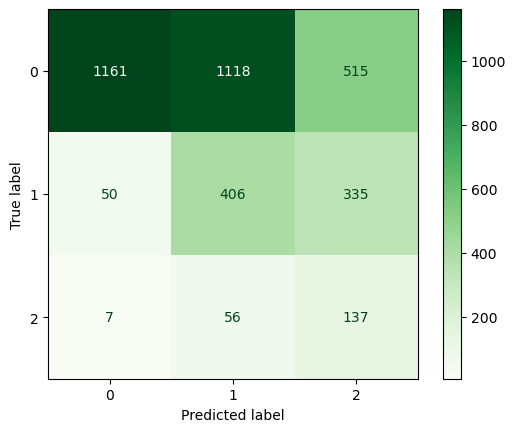

In [28]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [30]:
custom_recall(y_test, preds, cw_values)

0.6277581120943954

In [31]:
50+406+335,7+56+137

(791, 200)

In [34]:
1 - (57/991) #Boss - on a pure binary sensitivity scale we have ove 94%.... Use this later!!!

0.9424823410696266

The following technically doesn't belong here, however I wanted to anyways as I already had the code for the replicated train data here. Hence, the pickle reference on principle...

In [38]:
with open('model_base.pkl', 'rb') as f:
    foo = pickle.load(f)
    
trial_model = foo

In [40]:
trial_model[0]

TfidfVectorizer(lowercase=False, max_df=0.95, min_df=0.0, ngram_range=(1, 2))

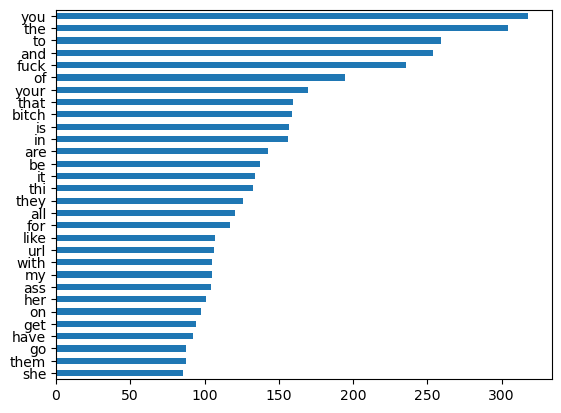

In [41]:
# cvec_ex = CountVectorizer(stop_words='english')
X_train_model = trial_model[0].fit_transform(X_train)
X_train_model = pd.DataFrame(X_train_model.todense(),
                          columns=trial_model[0].get_feature_names_out())

In [60]:
df_tfidf = pd.DataFrame(data={
    'token':trial_model[0].get_feature_names_out()
    ,'0':list(trial_model.named_steps['lr'].coef_[0])
    ,'1':list(trial_model.named_steps['lr'].coef_[1])
    ,'2':list(trial_model.named_steps['lr'].coef_[2])
})
print(df_tfidf.shape)

(112179, 4)


In [62]:
df_tfidf.sort_values('2', ascending=False)

,token,0,1,2
52660,kill,-3.853160,-2.193998,6.047158
64361,nigger,-3.548670,-0.853368,4.402038
35406,fuck,-5.217799,0.895805,4.321995
31387,faggot,-6.125869,1.978346,4.147522
76327,rape,-2.895911,-0.750569,3.646480
...,...,...,...,...
58588,mayb,1.012326,0.699369,-1.711695
14068,black,0.582412,1.361883,-1.944295
101733,url,2.810025,-0.661975,-2.148050
88151,stupid bitch,0.689643,1.682268,-2.371911


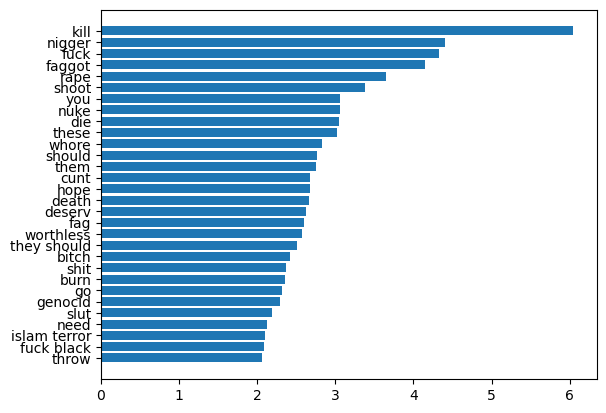

In [69]:
terms = 30
focus_tfidf = df_tfidf.sort_values('2', ascending=True).tail(terms)

plt.barh(focus_tfidf['token'], focus_tfidf['2']);

In [ ]:
df_tfidf[df_tfidf['token']=='you'] #Hmm, perhaps making direct threats

In [83]:
color_label = []
for i in range(terms):
    color_label.append('blue')
questionable = [4,7,11,14,16,18,19,21,24]
for i in questionable:
    color_label[i-1]='gold'
color_label[:5]

['blue', 'blue', 'blue', 'gold', 'blue']

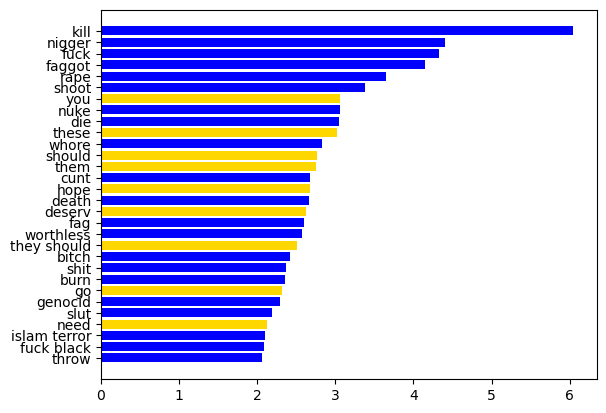

In [84]:
plt.barh(focus_tfidf['token'], focus_tfidf['2'], color=color_label);

In [ ]:
#Spoiler alert: Ultimately this one is the final model (and best... see at least SVMs). So, we'll go ahead and save it.

# with open('model_base.pkl', 'wb') as f:#wb ie write bytes
#     pickle.dump(trial_model, f)

Some other code I used for a bit of EDA of sorts.

In [ ]:
# trial_model.named_steps['lr'].coef_[0]

In [ ]:
# trial_model.named_steps['lr'].coef_[2]

In [ ]:
# len(trial_model.named_steps['lr'].coef_[2]) == len(trial_model.named_steps['tvec'].get_feature_names_out())

In [ ]:
# trial_model.named_steps['tvec'].get_feature_names_out()

In [ ]:
#Hmm, I'm honstly pretty pleased with those... Ie obviously, the higher the better. However, we have a lot of issues:
#1 is that often neutral or defensive language is unclear/smudges between the more extreme categories.
#2 Incitement aside, speach is not a crime. So, a one time offense woudln't likely call for confrontation. However,
#depending upon the severity[ie really really bad....] AND most importantly frequently...

#Let's examine a bit more. Maybe later we'll work on graphs... However, I think we'll keep this base approach.
#Ie weights seem to be the way to go and just make sure to check like we've been ding that we don't keep on adding more features
#and lose the 2 accuracy.

#I'll make a graph later, but for now let's look at the relative probabilities. Ie the plan is to go with whatever model,
#then have a variable of how many messages were sent like this? Ie let us confirm a few things:
#1 Anyhing misclassified is NOT 'decently/significantly' misclassifid.
    #or just hard things like a positive/defensive post that is vulgar...
#2 That anything classified correctly is also 'decently/significantly' such.

In [ ]:
hyper_pred_comparer

## A second wind - continuing with modeling

We'll keep the current data size, train test split, and weights. Now that we finally have a proper metric we're tuning for
we got this.

Note that I played around quite a bit with test size and noticed such great changes as it changed. Ie we were hovering
at around .52 'originally' when test size was 10.5k; .63 with the current 3845; a shocking .34ish with 2735. So, this definitely would seem to be a hyperparameer to tune, being based upon the relative resample distribution, however I am satisfied with the current results. As, accordingly to everybody - this is quite a difficult issue to do. And, in all honesty, a model'sperformance isn't so critical when it's going to have multiple messages to compare each other with AND finally have a human visually inspect the messages...
    Reminder that the above custom_recall accuracies were based upon Tiffany with Logreg.

I think I had another proclaimation but whatever. Let us continue and finally build the models. Oh, perhaps it was the acceptance that likely we will end up using all the features. Perhaps that'll change with forests and the like, but I suspect that trend will continue by cvec x logreg at least.

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('lr', LogisticRegression(max_iter=2500, multi_class='multinomial', class_weight=current_weights))
])

pipe_params = {'cvec__min_df' : [.00]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1),(1,2),(1,3)]
               ,'cvec__max_features' : [2000, 4000, 8000, None]
               ,'cvec__stop_words' : [None, 'english']
               }
scorer = make_scorer(custom_recall, weight_list=cw_values) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

#Not up to the challenge, but still 'decent'. Note the '1,3'

For the pevious cvec x logreg, as well as the many to com, they in short came disapointingly short of accurately predicting the matters. Perhaps I need to play with more hyperparameters though before I abandon thm.

However,please bear in mind - unlike logreg the following don't have a class_weight parameter. So, as we noticed above, how much of a part that plays IN ADDITION to the theortical encouragement of our pipe to go for the customer. 

In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1,3)]
               ,'cvec__max_features' : [14850, 14875, 14900]
               ,'cvec__stop_words' : ['english']
               ,'mnb__alpha': [1.0]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])
#Hmm, yeah that's not good... decent on 1s though. Notice i the documentations that the 

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('mnb', MultinomialNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,3), (2,3),(1,4)]
               ,'tvec__max_features' : [18000, 18050, 17950]
               ,'tvec__stop_words' : ['english']
               ,'mnb__alpha': [.98]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
#ote, this one ran pretty quickly.
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('gnb', GaussianNB())
])
pipe_params = {'cvec__min_df' : [.05]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1,2)]
               ,'cvec__max_features' : [2000, 1975, 2025]
               ,'cvec__stop_words' : [None]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('gnb', GaussianNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,2)]
               ,'tvec__max_features' : [14825, 14925, 14875]
               ,'tvec__stop_words' : [None]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

A new day and a new model to try, albeit it is in the family of the others. Might as well try. Fun fact when I was schmoozing earlier today with Eric, "More often than not, the logreg does as well if not better than the fancier models."

In [ ]:
#There's honestly more tuning to do, but given that we're still in the 31% range...
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('conb', ComplementNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1,3)]
               ,'cvec__max_features' : [16000, 20000]
               ,'cvec__stop_words' : ['english']
               ,'conb__alpha': [.9, .85]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('cong', ComplementNB())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [.95]
               ,'tvec__ngram_range' : [(1,3), (1,4)]
               ,'tvec__max_features' : [16000, 20000, 12000]
               ,'tvec__stop_words' : ['english']
               ,'cong__alpha': [1.0]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

Yeah, that last one is the worst thus far... More and more it seems that the weighting is critical. Fortunately, the Good Lord has spared us with SVC having a probability parameter. On principal I'll first try without it though.

In [ ]:
#NOTE that we need to turn probability to being true...

pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('svc', SVC(probability=True, class_weight=current_weights))
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [1.0]
               ,'cvec__ngram_range' : [(1,2)]
               ,'cvec__max_features' : [2000]
               ,'cvec__stop_words' : ['english']
               ,'svc__kernel': ['linear']
               ,'svc__C': [.95]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=5
                  ,scoring=scorer
                  ,verbose=3
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
#A meager .48, however compared to other models... Plus, the fact that this was essentially untuned... However,t his is obviously
#too cumbersome to implement, especially given that we won't make decisions from a sole tweet. However, definitely worth
#future investigations. Oh, such a shame we do not have the luxury to explore it.

#Now, let us at least do one attempt with Tiffany. Fortunately, we'll trim down some of the time, albeit with a loss in accuracy,
#by just using 3 cvs. Although computations it's likly also not reasonabl with present conditions, 3/5/24, the idea of
#seeing Tiffany wtih with SVec is too tempting to pass up. Recall how well she did earlier with LogReg (.63)!

#So, let this arduous journey continue!

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False))
    ,('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    ,('svc', SVC(probability=True, class_weight=current_weights))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [1.0]
               ,'tvec__ngram_range' : [(1,2)]
               ,'tvec__max_features' : [6000]
               ,'tvec__stop_words' : ['english']
               ,'svc__kernel': ['linear']
               ,'svc__C': [.95]
              }
scorer = make_scorer(custom_recall, weight_list=cw_values[1:]) #Note the 1: as we're now ignoring 0 for the scoring
gs = GridSearchCV(pipe
                  ,param_grid=pipe_params
                  ,cv=3 #For the sake of actually trying to get at least some model...
                  ,scoring=scorer
                  ,verbose=3
                 )

gs.fit(X_train, y_train)

print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

preds = trial_model.predict(X_test)
preds_prob = trial_model.predict_proba(X_test)
hyper_pred_comparer = pd.DataFrame({
    'cleaned_text':X_test
    ,'actual':y_test
    ,'pred':preds
    ,'p_0':preds_prob[:,0]
    ,'p_1':preds_prob[:,1]
    ,'p_2':preds_prob[:,2]
})

ConfusionMatrixDisplay.from_estimator(trial_model,X_test,y_test, cmap='Greens');

In [ ]:
class_twos = confusion_matrix(y_test, preds)[2]
class_ones = confusion_matrix(y_test, preds)[1]
(cw_values[1]*(class_ones[1]/sum(class_ones))+cw_values[2]*(class_twos[2]/sum(class_twos)))/sum(cw_values[1:])

In [ ]:
#This one totally has potential; eh wasn't that much higher than cvc. Regardless, feel the potential in them. I don't recall
#the relative recallfor 6k features with Tiffany x LogReg, but I think it was close to this. Regardless, unfortunately, the reality
#of our current computer computation makes this unfeasaible in the present.

Eh, you never know... As, we already have a huge overfitting problem, in general and exasperated via the repeated data. However, I am forcing myself to do at least one tree based model, on principal of not having used them before in my work at GA.

## Moving on

So, unsurprisingly we'll be going with TIffany's LogReg. However, let's try to see if we can improve accuracy by a number of other features:

In [ ]:
df = pd.read_csv('../data/cleaned_02_ii.csv')
print(df.shape)
df.head()

Besides what we laboured for re. text, we have:<br>
Platform<br>
Capital Sentance<br>
WC Cleaned Text<br>

Yeah, it's time for a new notebook. I'll go back aboveand pickle the model then.